In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [22]:
!pip install qhoptim

In [5]:
!conda install keras=2.3.1 -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ubuntu/miniconda3/envs/py3

  added / updated specs:
    - keras=2.3.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py37h06a4308_0         141 KB
    keras-2.3.1                |                0          12 KB
    keras-base-2.3.1           |           py37_0         495 KB
    openssl-1.1.1i             |       h27cfd23_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  keras-base         pkgs/main/linux-64::keras-base-2.3.1-py37_0

The following package

In [2]:
 #Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17993022828398494510
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3274618457875477408
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4232872575163048890
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31595870336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5370779830014107259
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
]


In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 
from qhoptim.tf import QHAdamOptimizer

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Optimizer
from keras.legacy import interfaces

class QHAdam(Optimizer):
    """QH-Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta_1 < 1. Generally close to 1.
        beta_2: float, 0 < beta_2 < 1. Generally close to 1.
        neu_1: float, 0 < neu_1 < 1. Default based on paper equals 0.7
        neu_2: float, 0 < neu_2 < 1. Default based on paper equals 1
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [QUASI-HYPERBOLIC MOMENTUM AND ADAM FOR DEEP LEARNING](
           https://openreview.net/pdf?id=S1fUpoR5FQ)
    """

    def __init__(self,
                 lr=0.001,
                 beta_1=0.999,
                 beta_2=0.999,
                 neu_1 = 0.7,
                 neu_2 = 1.,
                 epsilon=1e-3,
                 decay=0.,
                 amsgrad=False,
                 **kwargs):
        super(QHAdam, self).__init__(name="QHAdam",**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.learning_rate = K.variable(lr, name='lr')
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.neu_1 = K.variable(neu_1, name='neu_1')
            self.neu_2 = K.variable(neu_2, name='neu_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.learning_rate
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1


        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            m_t_adj = m_t/(1. - K.pow(self.beta_1, t))
            v_t_adj = v_t/(1. - K.pow(self.beta_2, t))
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr * ((1.- self.neu_1)*g + self.neu_1*(m_t_adj)) / \
                       (K.sqrt((1.-self.neu_2) * K.square(g) + self.neu_2 * vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr * ((1.-self.neu_1)*g + self.neu_1*(m_t_adj)) / \
                       (K.sqrt((1.-self.neu_2)*K.square(g) + self.neu_2 * v_t_adj) + self.epsilon)
            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.learning_rate)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'neu_1': float(K.get_value(self.neu_1)),
                  'neu_2': float(K.get_value(self.neu_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(QHAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


In [2]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset
import pickle5 as pickle
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V4_sim95.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [ ]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

### Utility function: plot_history, display_model_score

In [3]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [5]:
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())

In [6]:
input_shape  = X.shape
input_shape 

NameError: name 'X' is not defined

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()),  np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  128565
Val size:  42855
Test size:  42856


## Custom CNN

In [6]:
# 3d dimension for LSTM
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

# Conv1D with sequential data
# batch, steps, channels

# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(128565, 1900, 1)
(42856, 1900, 1)
(42855, 1900, 1)


In [7]:
# the best Mark I
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)

    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(2432, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="RMSprop", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 512)         4096      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 633, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 316, 256)          0         
_________________________________________________________________
flatten (Flatten)            (None, 80896)             0         
_________________________________________________________________
dense (Dense)                (None, 1211)             

In [58]:
# n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], 1
# nn.Conv1d with a kernel size of 1 and nn.Linear   give exactly the same results.

# use in dev 

#SGD
#RMSprop
#Adam
#Adadelta
#Adagrad
#Adamax
#Nadam
#Ftrl
#
#
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    #conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    #conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(512, kernel_size=8, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
   
    # Flatten NN
    flat = Flatten()(conv)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1900, 512)         4608      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 633, 512)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 316, 256)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 80896)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1211)            

In [6]:
# create_ModelII
## https://github.com/p-koo/learning_sequence_motifs/blob/master/code/models/cnn_25.py show best here 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
  #bn1 = BatchNormalization()(data)
  #act1 = Activation('relu')(bn1)
    
    conv = Conv1D(64, kernel_size=19, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
   
    # Flatten NN
    flat = Flatten()(x)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(512, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 64)          3264      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 63, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 63, 128)           155776    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 128)            512       
_________________________________________________________________
flatten (Flatten)            (None, 768)              

In [ ]:
# https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras

In [7]:
# create_ModelIII
#

def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
        
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(2432, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1216, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Flatten()(output)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 64)          2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 128)           512       
_________________________________________________________________
flatten (Flatten)            (None, 2432)             

In [8]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

In [9]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/CustomCNN.Adam.v4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
1005/1005 [==============================] - 9s 9ms/step - loss: 0.2960 - accuracy: 0.8797 - val_loss: 0.7383 - val_accuracy: 0.6584
 Learning rate:  0.001
Epoch 2/100
1005/1005 [==============================] - 8s 8ms/step - loss: 0.2203 - accuracy: 0.9142 - val_loss: 0.3606 - val_accuracy: 0.8430
 Learning rate:  0.001
Epoch 3/100
1005/1005 [==============================] - 8s 8ms/step - loss: 0.1980 - accuracy: 0.9234 - val_loss: 0.2516 - val_accuracy: 0.9000
 Learning rate:  0.001
Epoch 4/100
1005/1005 [==============================] - 8s 8ms/step - loss: 0.1840 - accuracy: 0.9298 - val_loss: 0.1947 - val_accuracy: 0.9239
 Learning rate:  0.001
Epoch 5/100
1005/1005 [==============================] - 8s 8ms/step - loss: 0.1725 - accuracy: 0.9356 - val_loss: 0.2364 - val_accuracy: 0.9031
 Learning rate:  0.001
Epoch 6/100
1005/1005 [==============================] - 8s 8ms/step - loss: 0.1629 - accuracy: 0.9381 - val_loss: 0.2206 - val_accuracy:

In [13]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.III.V4.h5') 

In [10]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

4018/4018 [==============================] - 8s 2ms/step - loss: 0.0201 - accuracy: 0.9945
Train loss:  0.02008160762488842
Train accuracy:  0.994539737701416
----------------------------------------------------------------------
1340/1340 [==============================] - 3s 2ms/step - loss: 0.2069 - accuracy: 0.9475
Val loss:  0.20690956711769104
Val accuracy:  0.9474506974220276
----------------------------------------------------------------------
1340/1340 [==============================] - 3s 2ms/step - loss: 0.2044 - accuracy: 0.9475
Test loss:  0.20440642535686493
Test accuracy:  0.9475219249725342


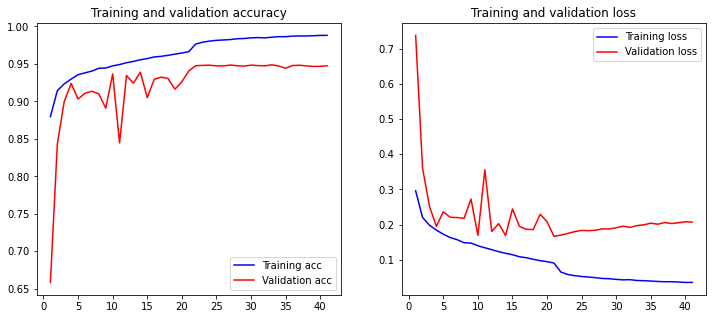

In [11]:
plot_history(history)

In [12]:
# Markk III
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     21596
           1       0.94      0.95      0.95     21260

    accuracy                           0.95     42856
   macro avg       0.95      0.95      0.95     42856
weighted avg       0.95      0.95      0.95     42856



In [13]:
print(classification_report(y_test, y_predict))

NameError: name 'y_predict' is not defined

In [ ]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

In [20]:
# 11/3/2021
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     22886
           1       0.95      0.91      0.93     22400

    accuracy                           0.93     45286
   macro avg       0.94      0.93      0.93     45286
weighted avg       0.93      0.93      0.93     45286



In [62]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     25564
           1       0.96      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



# Conclusion

In [ ]:
# IF you AveragePooling in any -> didn;t show the good performance so use Maxpooling 
# 1211 , 512 show the better performance  

# 2 CNN layer
# 2 Dense layer 

# Add

In [19]:
model.layers_by_depth

AttributeError: 'Functional' object has no attribute 'layers_by_depth'